# Task 1

### Import train and test data:

In [1]:
import os

parentdir = "../propaganda_dataset_v2"
train_file = "propaganda_train.tsv"
test_file = "propaganda_val.tsv"

train_path = os.path.join(parentdir,train_file)
test_path = os.path.join(parentdir,test_file)

In [2]:
import pandas as pd

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')

In [3]:
test_df=pd.read_csv(test_path,delimiter="\t",quotechar='|')

In [4]:
# put all data together

all_data_df = pd.concat([train_df, test_df])
print(len(all_data_df), len(train_df), len(test_df))

3200 2560 640


### TASK 0. Explore Data

#### a. Classes distribution in data

In [5]:
from nltk.probability import FreqDist

# STEP 1 - Find all classes and the frequency distribution
cls_fq_list = []
data_names = ["Train Data", "Test Data", "All Data"]
for i, df in enumerate([train_df, test_df, all_data_df]):
    cls_fq_list.append(FreqDist(df["label"]))
    #print(f"\nClasses in data {data_names[i]} includes\n{cls_fq_list[-1].items()}")

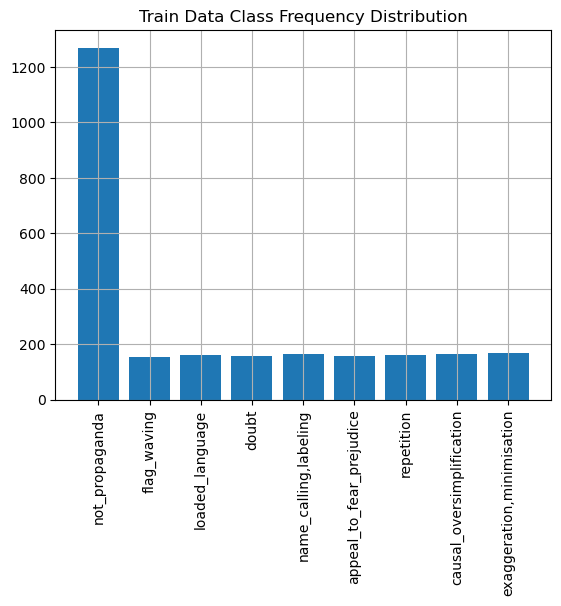

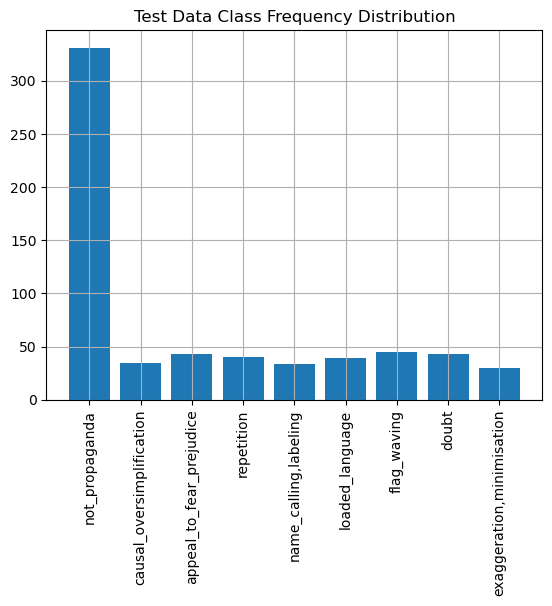

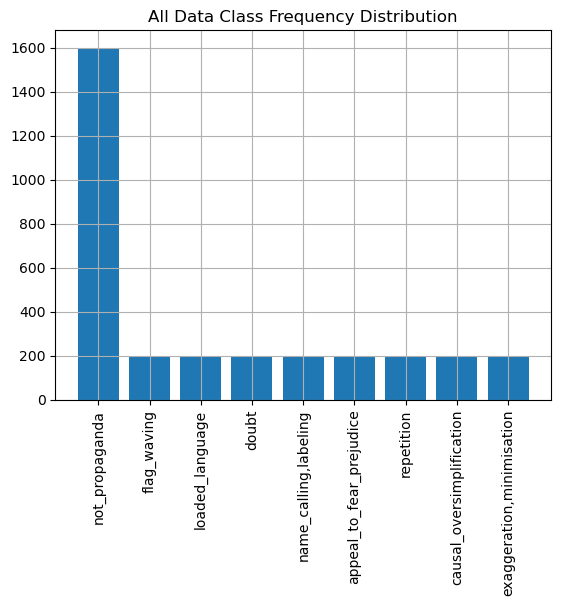

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 2 - Find the suitable graph to plot the frequency distribution
for i, cls_fq in enumerate(cls_fq_list):
    plt.bar(cls_fq.keys(), cls_fq.values())
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(f"{data_names[i]} Class Frequency Distribution")
    plt.show()

#### b. Sample and snippets length

In [7]:
# STEP 1 - init a dictionary to record samples length & snep length for each class
sent_len = {cls:[] for cls in cls_fq.keys()}
snip_len = {cls:[] for cls in cls_fq.keys()}

In [8]:
# STEP 2 - Iterate the training data
import string
import re

for cls,sample in zip(all_data_df["label"],all_data_df["tagged_in_context"]):
    # get sample length
    lowered = sample.lower()
    filtered = re.findall(r'\w+', lowered)
    removed = [word for word in filtered if word != "bos" and word != "eos"]
    sent_len[cls].append(len(removed))

    # get snippet length
    snippet = re.findall(r'bos(.*?)eos', ' '.join(filtered))[0].split()
    snip_len[cls].append(len(snippet)) # append the length
    

In [9]:
# STEP 3 - Iterate the dictionary and get mean of the items
sent_len_mean = dict()
for cls,lst in sent_len.items():
    sent_len_mean[cls] = {"Average": np.mean(lst), "Max": max(lst), "Sum": sum(lst)}

snip_len_mean = dict()
for cls,lst in snip_len.items():
    snip_len_mean[cls] = {"Average": np.mean(lst), "Max": max(lst), "Sum": sum(lst)}

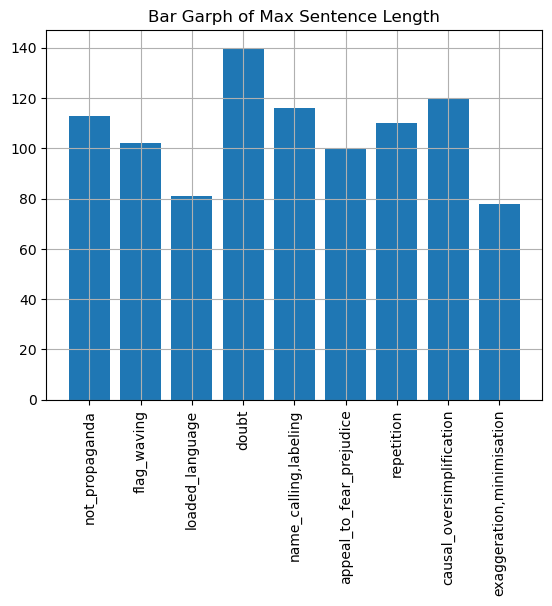

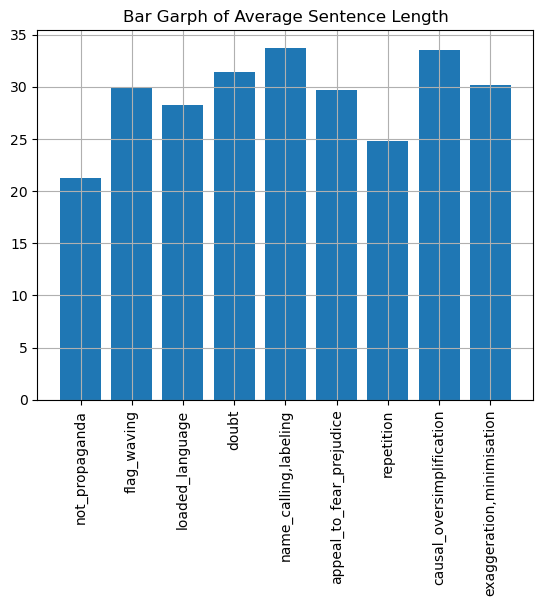

In [10]:
# STEP 4 - Visualise with a suitable graph

# sent len
plt.bar(sent_len_mean.keys(), [item["Max"] for item in sent_len_mean.values()])
plt.xticks(rotation=90)
plt.grid()
plt.title("Bar Garph of Max Sentence Length")
plt.show()

plt.bar(sent_len_mean.keys(), [item["Average"] for item in sent_len_mean.values()])
plt.xticks(rotation=90)
plt.grid()
plt.title("Bar Garph of Average Sentence Length")
plt.show()


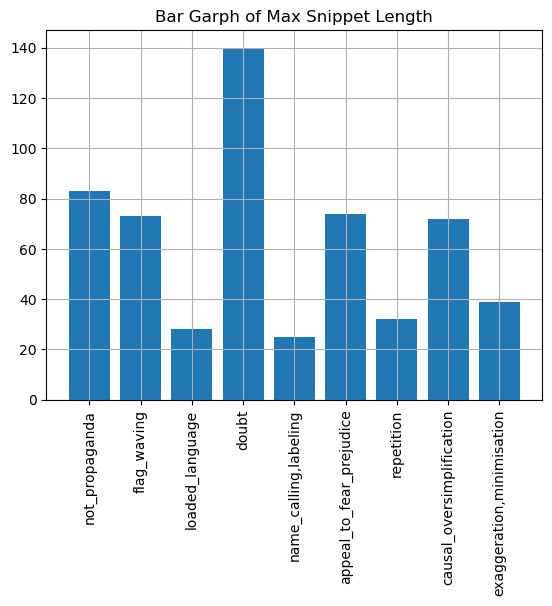

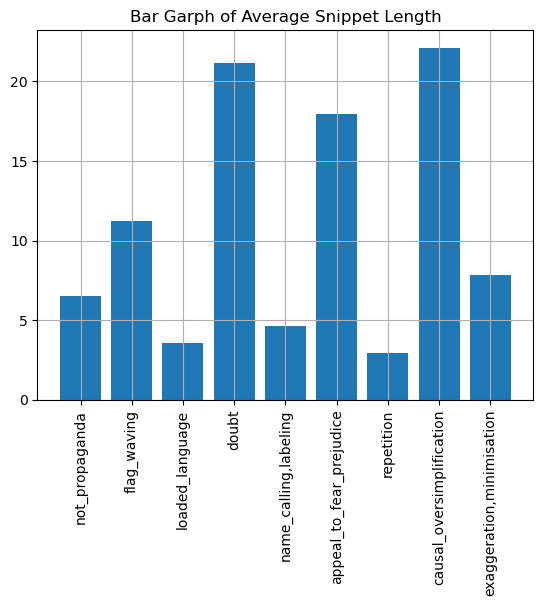

In [11]:
# snippet len
plt.bar(snip_len_mean.keys(), [item["Max"] for item in snip_len_mean.values()])
plt.xticks(rotation=90)
plt.grid()
plt.title("Bar Garph of Max Snippet Length")
plt.show()

plt.bar(snip_len_mean.keys(), [item["Average"] for item in snip_len_mean.values()])
plt.xticks(rotation=90)
plt.grid()
plt.title("Bar Garph of Average Snippet Length")
plt.show()

In [12]:
# STEP 5 - Visualise with a suitable table

sent_len_mean_df = pd.DataFrame(sent_len_mean)
sent_len_mean_df

,not_propaganda,flag_waving,loaded_language,doubt,"name_calling,labeling",appeal_to_fear_prejudice,repetition,causal_oversimplification,"exaggeration,minimisation"
Average,21.290625,29.995,28.26,31.42,33.745,29.695,24.845,33.56,30.22
Max,113.000000,102.000,81.00,140.00,116.000,100.000,110.000,120.00,78.00
Sum,34065.000000,5999.000,5652.00,6284.00,6749.000,5939.000,4969.000,6712.00,6044.00


In [13]:
snip_len_mean_df = pd.DataFrame(snip_len_mean)
snip_len_mean_df

,not_propaganda,flag_waving,loaded_language,doubt,"name_calling,labeling",appeal_to_fear_prejudice,repetition,causal_oversimplification,"exaggeration,minimisation"
Average,6.53875,11.22,3.545,21.135,4.635,17.935,2.95,22.115,7.825
Max,83.00000,73.00,28.000,140.000,25.000,74.000,32.00,72.000,39.000
Sum,10462.00000,2244.00,709.000,4227.000,927.000,3587.000,590.00,4423.000,1565.000


### TASK 1. METHOD 1. Propaganda technique classification using Logistic Regression model

In [14]:
from nltk.probability import FreqDist
import re

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [15]:
# STEP 1 - Assign each propaganda technique a label

cls_fq = FreqDist(train_df["label"][train_df["label"]!="not_propaganda"])
techniques = {item: idx for idx, item in enumerate(list(cls_fq.keys()))} 

print(techniques)

{'flag_waving': 0, 'loaded_language': 1, 'doubt': 2, 'name_calling,labeling': 3, 'appeal_to_fear_prejudice': 4, 'repetition': 5, 'causal_oversimplification': 6, 'exaggeration,minimisation': 7}


In [16]:
# STEP 2 - Make data into a list of tuples where each contain a snippet and a label 

def span_identification(df):
    snippets = [] 
    
    for cls,sample in zip(df["label"][df["label"] != "not_propaganda"] ,df["tagged_in_context"][df["label"] != "not_propaganda"]):
        # find the snippet and join them back to a string
        lowered = sample.lower()
        filtered = re.findall(r'\w+', lowered)
        snippet = " ".join(re.findall(r'bos(.*?)eos', ' '.join(filtered))[0].split())
        # append the snippet string
        snippets.append((snippet, techniques[cls]))    
    
    Xsamples, Ycls = zip(*snippets)

    return Xsamples, Ycls

def sample_preprocessing(df):
    samples = [] 
    
    for cls,sample in zip(df["label"][df["label"] != "not_propaganda"] ,df["tagged_in_context"][df["label"] != "not_propaganda"]):
        # filtered sample and join them back to a string
        lowered = sample.lower()
        filtered = re.findall(r'\w+', lowered)
        removed = [word for word in filtered if word != "bos" and word != "eos"]
        joined = ' '.join(removed)
        # append the processed sample string
        samples.append((joined, techniques[cls]))    
    
    Xsamples, Ycls = zip(*samples)

    return Xsamples, Ycls


In [17]:
# STEP 3 - Get train and test samples and labels

train_Xsamples1, train_Ycls1 = span_identification(train_df)
test_Xsamples1, test_Ycls1 = span_identification(test_df)
Xsamples1, Ycls1 = span_identification(all_data_df)

train_Xsamples2, train_Ycls2 = sample_preprocessing(train_df)
test_Xsamples2, test_Ycls2 = sample_preprocessing(test_df)
Xsamples2, Ycls2 = sample_preprocessing(all_data_df)

train_Xsamples = train_Xsamples1 + train_Xsamples2
test_Xsamples = test_Xsamples1 + test_Xsamples2
Xsamples = Xsamples1 + Xsamples2

train_Ycls = train_Ycls1 + train_Ycls2
test_Ycls = test_Ycls1 + test_Ycls2
Ycls = Ycls1 + Ycls2

In [18]:
# STEP 4 - making a bag-of-words representation of each sentence using CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit(Xsamples)

# Printing the identified Unique words along with their indices
#print("Vocabulary: ", vectorizer.vocabulary_)
 
# Encode the sents
train_Xvectors = vectorizer.transform(train_Xsamples)
test_Xvectors = vectorizer.transform(test_Xsamples)

# Print the representations of the 1st sample in test data
print("Snippet: \n", train_Xsamples[200])
print("Vector representations: \n", train_Xvectors[200])

Snippet: 
 the plague is impossible to eradicate
Vector representations: 
   (0, 2168)	1
  (0, 3133)	1
  (0, 3369)	1
  (0, 4614)	1
  (0, 6170)	1
  (0, 6259)	1


In [19]:
# STEP 4-a - Train a logistic classifier on the training data and evaluate it on testing data

classifier = LogisticRegression(max_iter=500)
classifier.fit(train_Xvectors,train_Ycls)

test_predict = classifier.predict(test_Xvectors)
test_mse = mean_squared_error(test_predict, test_Ycls)

print(f"mean square error is {test_mse}")

mean square error is 6.4288025889967635



 The F1 scores for each of the classes are: [0.64705882 0.28395062 0.375      0.30656934 0.4137931  0.43010753
 0.42857143 0.39705882]

 The average F1 score is: 0.4102637082887366



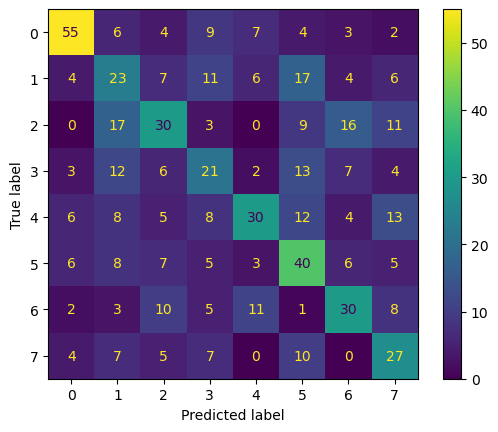

In [20]:
# STEP 4-b - Show confusion matrix

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(test_Ycls, test_predict, average='macro')
f1_scores = f1_score(test_Ycls, test_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(test_Ycls, test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

In [21]:
# STEP 5-a - Train a MultinomialNB classifier on the training data and evaluate it on testing data

classifier = MultinomialNB()
classifier.fit(train_Xvectors,train_Ycls)

test_predict = classifier.predict(test_Xvectors)
test_mse = mean_squared_error(test_predict, test_Ycls)

print(f"mean square error is {test_mse}")


mean square error is 7.088996763754046



 The F1 scores for each of the classes are: [0.57731959 0.18181818 0.47959184 0.23214286 0.4260355  0.33333333
 0.43434343 0.39694656]

 The average F1 score is: 0.3826914123556803



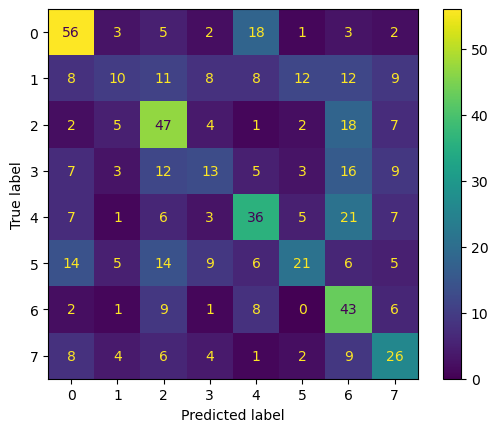

In [22]:
# STEP 5-b - Show confusion matrix

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(test_Ycls, test_predict, average='macro')
f1_scores = f1_score(test_Ycls, test_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(test_Ycls, test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

### TASK 1. METHOD 2. Propaganda technique classification using RNN 

#### a. Prepare Data

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import tqdm

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [24]:
# Preprocess the text in data
def get_snippet(sample):
    lowered = sample.lower()
    filtered = re.findall(r'\w+', lowered)
    return re.findall(r'bos(.*?)eos', ' '.join(filtered))[0].split()

def preprocess_text(sample):
    # filtered sample and return it in a list
    lowered = sample.lower()
    filtered = re.findall(r'\w+', lowered)
    removed = [word for word in filtered if word != "bos" and word != "eos"]
    return removed

def preprocess_label(label):
    return techniques[label]
    
def preprocess_dataframe(data_df):
    df1 = data_df[['label','tagged_in_context']]  # copy dataframe
    df2 = data_df[['label','tagged_in_context']]  # copy dataframe
    df1['tagged_in_context'] = data_df['tagged_in_context'].apply(preprocess_text) # process text
    df2['tagged_in_context'] = data_df['tagged_in_context'].apply(get_snippet) # get snippet
    df = pd.concat([df1, df2])
    df['label'] = df['label'].apply(preprocess_label) # process label
    
    return df

train_df_prep = preprocess_dataframe(train_df[train_df["label"]!="not_propaganda"])
rem_df_prep = preprocess_dataframe(test_df[test_df["label"]!="not_propaganda"])
all_df_prep = preprocess_dataframe(all_data_df[all_data_df["label"]!="not_propaganda"])

In [25]:
# Split data
test_df_prep, val_df_prep = train_test_split(rem_df_prep, test_size=0.5, random_state=42)


In [26]:
# Encode text - transfer text to values

# get all vocabs
vocab = set([word for phrase in all_df_prep['tagged_in_context'] for word in phrase])
# get index for each vocab
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

def encode_phrase(phrase):
    return [word_to_idx[word] for word in phrase]

# encode text data
train_df_prep['tagged_in_context'] = train_df_prep['tagged_in_context'].apply(encode_phrase)
val_df_prep['tagged_in_context'] = val_df_prep['tagged_in_context'].apply(encode_phrase)
test_df_prep['tagged_in_context'] = test_df_prep['tagged_in_context'].apply(encode_phrase)


In [27]:
# Pad the encoded data - Ensure a fixed length

max_length = max(all_df_prep['tagged_in_context'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

train_df_prep['tagged_in_context'] = train_df_prep['tagged_in_context'].apply(lambda x: pad_sequence(x, max_length))
val_df_prep['tagged_in_context'] = val_df_prep['tagged_in_context'].apply(lambda x: pad_sequence(x, max_length))
test_df_prep['tagged_in_context'] = test_df_prep['tagged_in_context'].apply(lambda x: pad_sequence(x, max_length))

#### Create Dataset and Dataloader

In [28]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['tagged_in_context'].values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_df_prep)  # text shape = (num_sample, max_sample_len), label shape = (num_sample, 1)
val_dataset = SentimentDataset(val_df_prep)
test_dataset = SentimentDataset(test_df_prep)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Create and Train Model

In [29]:

class RNNSentenceModel(nn.Module):
    """RNN model for sentence classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, 
                 bidirectional=True, dropout=0.5):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        # Calculate input size for final fully connected layer
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        
    def forward(self, text):
        # text = [batch size, seq len]
        
        # Embed the text
        embedded = self.embedding(text)
        # embedded = [batch size, seq len, embedding dim]
        
        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded)
        # output = [batch size, seq len, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        # hidden = [batch size, hidden dim * n directions]
            
        # Pass through fully connected layer
        output = self.fc(hidden)
        # output = [batch size, output dim]
        
        return output

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
num_layers = 3
output_size = 8

model = RNNSentenceModel(vocab_size, embed_size, hidden_size, output_size)


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### EARLY STOPPING ###
# Set values for early stopping hyperparameters
patience = 4              # the number of epochs to wait before stopping
min_delta = 0          # the tolerance in loss to qualify as an improvement
patience_counter = 0     # to keep track of the number of epochs to wait
best_loss = float('inf') # to keep track of the best loss so far
epoch_checkpoint = 7
### EARLY STOPPING ###

train_losses = []
val_losses = []
best_losses = []

num_epochs = 70
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    val_loss = 0
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    for texts, labels in val_loader:
        optimizer.zero_grad()
        
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()

    print("epoch: {} - train loss: {:.4f} val loss: {:.4f} best_val_loss {:.4f}".format(
        epoch,
        train_loss / len(train_loader),
        val_loss / len(val_loader),
        best_loss - min_delta))
    
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    best_losses.append((best_loss - min_delta))
   

    ### Early Stopping ###
    if epoch % 5 == 0:
        # check if validation loss is larger than best loss so far 
        if val_losses[-1] < best_loss - min_delta:  # if val_loss is smaller than best_loss
            patience_counter = 0              # reset patience counter
            best_loss = val_losses[-1]              # update best_loss
        else:
            patience_counter += 1
            print(f"Validation loss to much! Update patience counter {patience_counter}")
        
        # check if validation loss is increasing over the past n epochs 
        if patience_counter > patience:
            break
            
        ### Early Stopping ends ###

  1%|▋                                           | 1/70 [00:13<15:19, 13.33s/it]

epoch: 0 - train loss: 2.0477 val loss: 1.9687 best_val_loss inf


  3%|█▎                                          | 2/70 [00:27<15:50, 13.98s/it]

epoch: 1 - train loss: 1.8269 val loss: 1.9251 best_val_loss 1.9687


  4%|█▉                                          | 3/70 [00:42<16:09, 14.47s/it]

epoch: 2 - train loss: 1.5264 val loss: 1.8690 best_val_loss 1.9687


  6%|██▌                                         | 4/70 [00:56<15:21, 13.97s/it]

epoch: 3 - train loss: 1.1903 val loss: 2.0270 best_val_loss 1.9687


  7%|███▏                                        | 5/70 [01:10<15:10, 14.01s/it]

epoch: 4 - train loss: 0.8926 val loss: 2.1833 best_val_loss 1.9687


  9%|███▊                                        | 6/70 [01:25<15:35, 14.61s/it]

epoch: 5 - train loss: 0.6638 val loss: 2.3170 best_val_loss 1.9687
Validation loss to much! Update patience counter 1


 10%|████▍                                       | 7/70 [01:41<15:35, 14.85s/it]

epoch: 6 - train loss: 0.5191 val loss: 2.4501 best_val_loss 1.9687


 11%|█████                                       | 8/70 [01:56<15:30, 15.01s/it]

epoch: 7 - train loss: 0.3894 val loss: 2.6654 best_val_loss 1.9687


 13%|█████▋                                      | 9/70 [02:11<15:15, 15.01s/it]

epoch: 8 - train loss: 0.3446 val loss: 2.6871 best_val_loss 1.9687


 14%|██████▏                                    | 10/70 [02:27<15:13, 15.22s/it]

epoch: 9 - train loss: 0.2696 val loss: 2.7463 best_val_loss 1.9687


 16%|██████▊                                    | 11/70 [02:43<15:07, 15.38s/it]

epoch: 10 - train loss: 0.2422 val loss: 2.8788 best_val_loss 1.9687
Validation loss to much! Update patience counter 2


 17%|███████▎                                   | 12/70 [02:59<15:18, 15.83s/it]

epoch: 11 - train loss: 0.1915 val loss: 3.1956 best_val_loss 1.9687


 19%|███████▉                                   | 13/70 [03:15<14:51, 15.64s/it]

epoch: 12 - train loss: 0.1692 val loss: 3.2131 best_val_loss 1.9687


 20%|████████▌                                  | 14/70 [03:30<14:40, 15.72s/it]

epoch: 13 - train loss: 0.1654 val loss: 3.1178 best_val_loss 1.9687


 21%|█████████▏                                 | 15/70 [03:46<14:21, 15.66s/it]

epoch: 14 - train loss: 0.1680 val loss: 3.3576 best_val_loss 1.9687


 23%|█████████▊                                 | 16/70 [04:02<14:09, 15.73s/it]

epoch: 15 - train loss: 0.1518 val loss: 3.3674 best_val_loss 1.9687
Validation loss to much! Update patience counter 3


 24%|██████████▍                                | 17/70 [04:18<13:59, 15.85s/it]

epoch: 16 - train loss: 0.1422 val loss: 3.4212 best_val_loss 1.9687


 26%|███████████                                | 18/70 [04:35<13:54, 16.06s/it]

epoch: 17 - train loss: 0.1282 val loss: 3.5892 best_val_loss 1.9687


 27%|███████████▋                               | 19/70 [04:50<13:32, 15.93s/it]

epoch: 18 - train loss: 0.1251 val loss: 3.3629 best_val_loss 1.9687


 29%|████████████▎                              | 20/70 [05:07<13:27, 16.16s/it]

epoch: 19 - train loss: 0.1329 val loss: 3.3719 best_val_loss 1.9687


 30%|████████████▉                              | 21/70 [05:24<13:30, 16.54s/it]

epoch: 20 - train loss: 0.1303 val loss: 3.5308 best_val_loss 1.9687
Validation loss to much! Update patience counter 4


 31%|█████████████▌                             | 22/70 [05:41<13:16, 16.60s/it]

epoch: 21 - train loss: 0.1211 val loss: 3.5188 best_val_loss 1.9687


 33%|██████████████▏                            | 23/70 [05:57<12:47, 16.33s/it]

epoch: 22 - train loss: 0.1117 val loss: 3.5761 best_val_loss 1.9687


 34%|██████████████▋                            | 24/70 [06:12<12:22, 16.15s/it]

epoch: 23 - train loss: 0.1056 val loss: 3.7101 best_val_loss 1.9687


 36%|███████████████▎                           | 25/70 [06:29<12:16, 16.37s/it]

epoch: 24 - train loss: 0.1053 val loss: 3.7716 best_val_loss 1.9687


 36%|███████████████▎                           | 25/70 [06:45<12:10, 16.24s/it]

epoch: 25 - train loss: 0.0985 val loss: 3.7245 best_val_loss 1.9687
Validation loss to much! Update patience counter 5


In [31]:
model.eval()
correct = 0
total = 0
all_predict = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        all_predict += predicted
        all_labels += labels
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 35.60%



 The F1 scores for each of the classes are: [0.55421687 0.35443038 0.35294118 0.32911392 0.28169014 0.31818182
 0.34285714 0.28571429]

 The average F1 score is: 0.3523932169170316



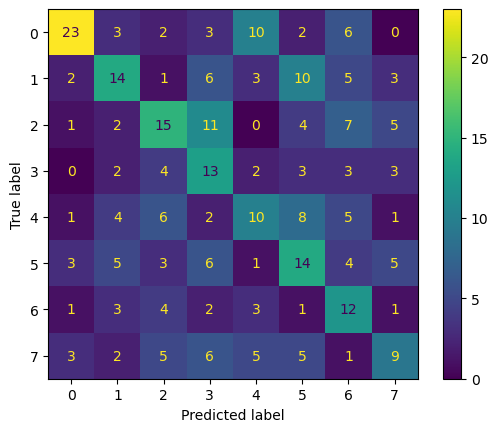

In [32]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(all_labels, all_predict, average='macro')
f1_scores = f1_score(all_labels, all_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(all_labels, all_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

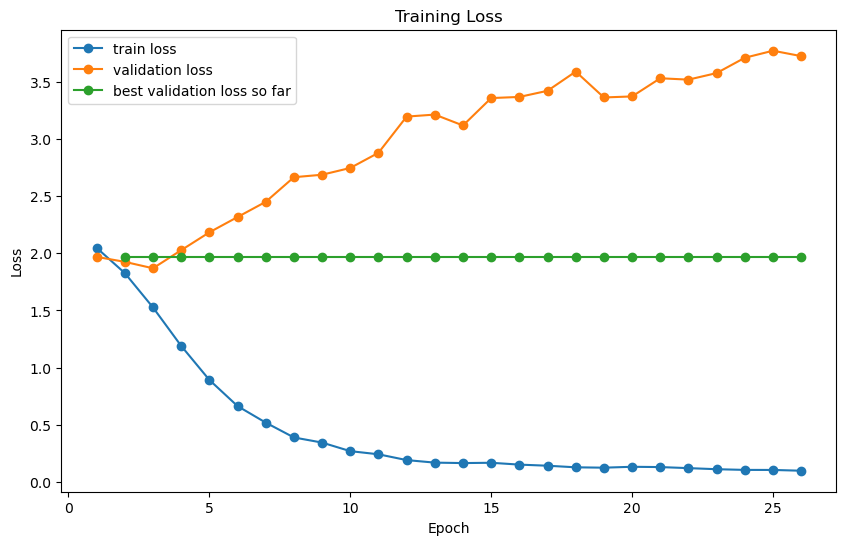

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="train loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o',  label="validation loss")
plt.plot(range(1, len(best_losses) + 1), best_losses, marker='o',  label="best validation loss so far")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()